In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [3]:
# Uncomment and run this cell if you're on Colab or Kaggle
#!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter2=True)

/home/jupyter-stephenhoward330/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [4]:
from utils import *
setup_chapter()

Using transformers v4.13.0
Using datasets v1.16.1


In [5]:
%cd ..

/home/jupyter-stephenhoward330


## Get Data!

In [6]:
from datasets import load_dataset

tweets_ds = load_dataset("csv", data_files="training.1600000.processed.noemoticon.csv", sep=",", 
                      names=['sentiment', 'id', 'date', 'query', 'user_id', 'text'], encoding="latin")

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
tweets_ds

DatasetDict({
    train: Dataset({
        features: ['sentiment', 'id', 'date', 'query', 'user_id', 'text'],
        num_rows: 1600000
    })
})

### Cleanup the data some

In [8]:
tweets_ds["train"].features

{'sentiment': Value(dtype='int64', id=None),
 'id': Value(dtype='int64', id=None),
 'date': Value(dtype='string', id=None),
 'query': Value(dtype='string', id=None),
 'user_id': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None)}

In [9]:
from datasets import Value

tweets_ds = tweets_ds.remove_columns(['id', 'date', 'query', 'user_id'])
tweets_ds = tweets_ds.cast_column("sentiment", Value(dtype='bool', id=None))
tweets_ds = tweets_ds.cast_column("sentiment", Value(dtype='int64', id=None))
tweets_ds = tweets_ds.rename_column("sentiment", "label")

Casting the dataset:   0%|          | 0/160 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/160 [00:00<?, ?ba/s]

In [10]:
tweets_ds["train"].features

{'label': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None)}

### Now split it up

In [11]:
from datasets import DatasetDict

tweets_with_test = tweets_ds['train'].train_test_split(test_size=0.2, seed=7)
tweets_2 = tweets_with_test['test'].train_test_split(test_size=0.5, seed=42)
tweets = DatasetDict({
    "train": tweets_with_test['train'], 
    "validation": tweets_2['train'], 
    "test": tweets_2['test']
})
tweets

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1280000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 160000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 160000
    })
})

## Looking at the data

In [12]:
tweets.set_format(type="pandas")
df = tweets["train"][:]
df.head()

,label,text
0,0,I'm disappointed the Spurs lost tonite. It's n...
1,1,changing my nickname
2,0,i just learned the hard way that FireWire 800 ...
3,0,my chest hurts
4,1,I think of things I want in life - I manifest.


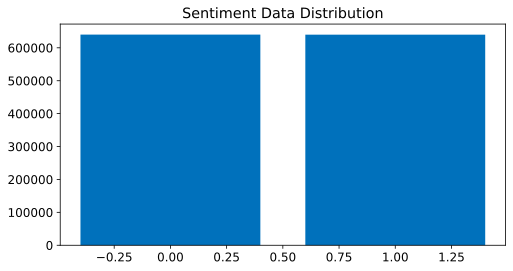

In [15]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")
plt.show()

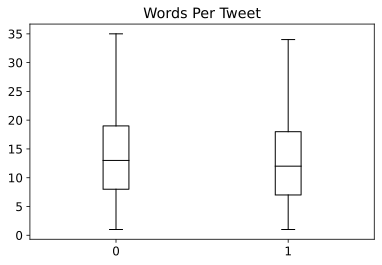

In [16]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [17]:
tweets.reset_format()

## Tokenize!

In [18]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

2022-10-03 15:37:46.826868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 15:37:47.028658: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 15:37:47.678310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-03 15:37:47.678421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [19]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [20]:
tweets_encoded = tweets.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [21]:
tweets_encoded

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 1280000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 160000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 160000
    })
})

## Train!

In [27]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
device

device(type='cuda')

In [29]:
import torch 

def get_available_devices():
    """Get IDs of all available GPUs.

    Returns:
        device (torch.device): Main device (GPU 0 or CPU).
        gpu_ids (list): List of IDs of all GPUs that are available.
        device_props (list): List of gpu _CudaDeviceProperties dictionaries generally ordered fastest to slowest
    """
    gpu_ids = []
    device_props = []
    if torch.cuda.is_available():
        gpu_ids += [gpu_id for gpu_id in range(torch.cuda.device_count())]
        for i in range(torch.cuda.device_count()):
            device_props.append(torch.cuda.get_device_properties(i))
        device = torch.device(f'cuda:{gpu_ids[0]}')
        torch.cuda.set_device(device)
    else:
        device = torch.device('cpu')

    return device, gpu_ids, device_props 

device, gpu_ids, device_props = get_available_devices()
print(device)
print(gpu_ids)
print(device_props)

cuda:0
[0, 1]
[_CudaDeviceProperties(name='NVIDIA TITAN V', major=7, minor=0,
total_memory=12066MB, multi_processor_count=80),
_CudaDeviceProperties(name='NVIDIA TITAN V', major=7, minor=0,
total_memory=12066MB, multi_processor_count=80)]


In [23]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [24]:
import gc 

gc.collect()
torch.cuda.empty_cache()

In [35]:
from transformers import Trainer, TrainingArguments

batch_size = 8
logging_steps = len(tweets_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-sentiment"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  logging_strategy="no",
                                  push_to_hub=False, 
                                  report_to="none",
                                  log_level="error"
                                 )

In [38]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tweets_encoded["validation"],
                  eval_dataset=tweets_encoded["test"],
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.344600,0.850113,0.850078
2,No log,0.373666,0.852175,0.852174


/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; wi

/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/tljh/user/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; wi

TrainOutput(global_step=20000, training_loss=0.32737021484375, metrics={'train_runtime': 5222.2249, 'train_samples_per_second': 61.277, 'train_steps_per_second': 3.83, 'total_flos': 1.415745323136e+16, 'train_loss': 0.32737021484375, 'epoch': 2.0})

In [39]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Mon Oct  3 17:28:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| 45

#### Our F1 and accuracy after 1 epoch on a smaller dataset was 0.85 and after two epochs, it increased slightly to 0.852. This is compared to 0.77 and 0.8 after 1 and 2 epochs, respectively, with the RNN.

#### I used the smaller dataset since training the full model of over a million tweets, even with two GPUs, would take about 6 hours. That was reduced to 40 minutes with the smaller dataset of 20,000 tweets in training and eval.